In [1]:
%matplotlib inline

In [2]:
from braindecode.util import set_random_seeds, np_to_var, var_to_np
import matplotlib.pyplot as plt
from moabb.datasets import BNCI2014001, Cho2017, PhysionetMI
from moabb.paradigms import MotorImagery
import numpy as np
from numpy.random import RandomState
import pickle
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import mne

import start_kits.util.shallow_net
from start_kits.util.utilfunc import get_balanced_batches
from start_kits.util.preproc import plot_confusion_matrix

cuda = torch.cuda.is_available()
print('gpu: ', cuda)
device = 'cuda' if cuda else 'cpu'

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
rng = RandomState(seed)

/home/ducanh/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu:  True


In [4]:
import torchmetrics
from torchmetrics import CohenKappa, F1Score, Precision, Recall

To download source MI datasets, we will use MOABB. By default, the datasets are downloaded in a `mne_data` folder in your home directory. To change this default repository, uncomment the next lines of codes and indicate the chosen path.

In [3]:
# window_size = min(X_src1.shape[2], X_src2.shape[2], X_tgt.shape[2])

# X_train = np.concatenate((X_src1[:, :, :window_size], X_src2[:, :, :window_size], X_tgt[:100, :, :window_size]))
# y_train = np.concatenate((y_src1, y_src2, y_tgt[:100]))

# X_val = X_tgt[100:150, :, :window_size]
# y_val = y_tgt[100:150]

# X_test = X_tgt[150:, :, :window_size]
# y_test = y_tgt[150:]

np_root = '/home/ducanh/hain/hungp/NeurIPS_BEETL/numpy_data_binary'

X_train = np.load(f'{np_root}/X_train.npy')
y_train = np.load(f'{np_root}/y_train.npy')

X_val = np.load(f'{np_root}/X_val.npy')
y_val = np.load(f'{np_root}/y_val.npy')

X_test = np.load(f'{np_root}/X_test.npy')
y_test = np.load(f'{np_root}/y_test.npy')

window_size = 256

print("Train:  there are {} trials with {} electrodes and {} time samples".format(*X_train.shape))
print("\nValidation: there are {} trials with {} electrodes and {} time samples".format(*X_val.shape))
print("\nTest: there are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

Train:  there are 328 trials with 32 electrodes and 256 time samples

Validation: there are 328 trials with 32 electrodes and 256 time samples

Test: there are 328 trials with 32 electrodes and 256 time samples


In [4]:
class TrainObject(object):
    def __init__(self, X, y):
        assert len(X) == len(y)
        # Normalised, you could choose other normalisation strategy
        mean = np.mean(X,axis=1,keepdims=True)
        # here normalise across channels as an example, unlike the in the sleep kit
        std = np.std(X, axis=1, keepdims=True)
        X = (X - mean) / std
        # we scale it to 1000 as a better training scale of the shallow CNN
        # according to the orignal work of the paper referenced above
        self.X = X.astype(np.float32) * 1e3
        self.y = y.astype(np.int64)

train_set = TrainObject(X_train, y=y_train)
valid_set = TrainObject(X_val, y=y_val)
test_set = TrainObject(X_test, y=y_test)

New model

In [5]:
in_chans = X_train.shape[1]
labelsize = len(np.unique(y_train))
# model = start_kits.util.shallow_net.EEGShallowClassifier(in_chans, labelsize, window_size, return_feature=False)

In [6]:
from braindecode.models import ShallowFBCSPNet, EEGNetv1, EEGNetv4
# model = ShallowFBCSPNet(
#     in_chans = 32,
#     n_classes = 2,
#     input_window_samples=256,
#     final_conv_length='auto',
# )

model = EEGNetv4(
    in_chans = in_chans,
    n_classes = labelsize,
    input_window_samples=256,
)


In [7]:
if cuda:
    model.cuda()

End of new model.

In [9]:
labelsize

2

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 0
Train  Loss: 0.69146
Train  Accuracy: 53.6%
Valid  Loss: 0.69459
Valid  Accuracy: 48.9%
model saved
[[592 416]
 [633 411]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


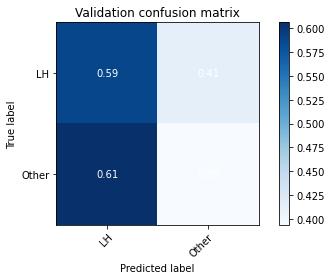

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 1
Train  Loss: 0.68509
Train  Accuracy: 58.5%
Valid  Loss: 0.69220
Valid  Accuracy: 52.8%
model saved
[[719 289]
 [680 364]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


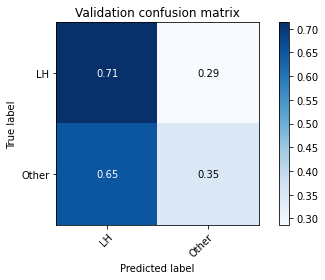

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 2
Train  Loss: 0.66301
Train  Accuracy: 66.1%
Valid  Loss: 0.67881
Valid  Accuracy: 59.7%
model saved
[[735 273]
 [553 491]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


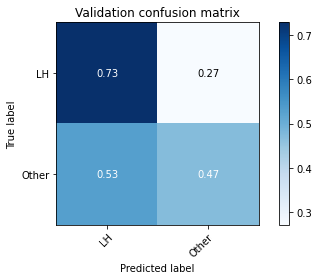

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 3
Train  Loss: 0.59998
Train  Accuracy: 73.4%
Valid  Loss: 0.62959
Valid  Accuracy: 69.6%
model saved
[[803 205]
 [419 625]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


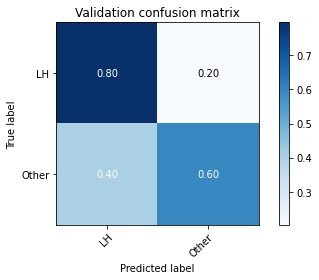

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 4
Train  Loss: 0.52422
Train  Accuracy: 77.7%
Valid  Loss: 0.54590
Valid  Accuracy: 78.9%
model saved
[[829 179]
 [253 791]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


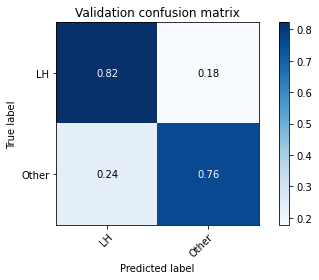

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 5
Train  Loss: 0.47545
Train  Accuracy: 79.8%
Valid  Loss: 0.46760
Valid  Accuracy: 84.7%
model saved
[[805 203]
 [110 934]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


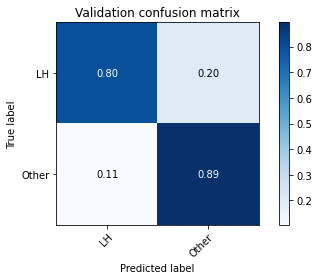

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 6
Train  Loss: 0.44175
Train  Accuracy: 81.7%


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Valid  Loss: 0.41172
Valid  Accuracy: 85.5%
model saved
[[766 242]
 [ 55 989]]
Normalized confusion matrix


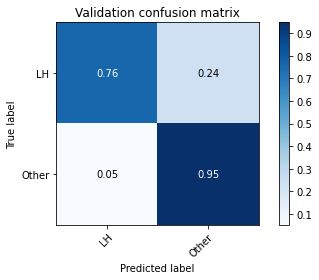

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 7
Train  Loss: 0.41463
Train  Accuracy: 82.8%


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Valid  Loss: 0.39060
Valid  Accuracy: 83.4%
Epoch 8
Train  Loss: 0.39607
Train  Accuracy: 83.3%
Valid  Loss: 0.39182
Valid  Accuracy: 81.7%
Epoch 9
Train  Loss: 0.37927
Train  Accuracy: 83.7%
Valid  Loss: 0.40215
Valid  Accuracy: 80.5%
Epoch 10
Train  Loss: 0.36544
Train  Accuracy: 84.2%
Valid  Loss: 0.41337
Valid  Accuracy: 79.6%
Epoch 11
Train  Loss: 0.35166
Train  Accuracy: 84.7%
Valid  Loss: 0.41180
Valid  Accuracy: 79.3%
Epoch 12
Train  Loss: 0.34019
Train  Accuracy: 85.3%
Valid  Loss: 0.41360
Valid  Accuracy: 79.0%
Epoch 13
Train  Loss: 0.33013
Train  Accuracy: 85.8%
Valid  Loss: 0.41991
Valid  Accuracy: 78.4%
Epoch 14
Train  Loss: 0.32130
Train  Accuracy: 86.1%
Valid  Loss: 0.42976
Valid  Accuracy: 78.0%
Epoch 15
Train  Loss: 0.31239
Train  Accuracy: 86.4%
Valid  Loss: 0.42484
Valid  Accuracy: 78.6%
Epoch 16
Train  Loss: 0.30492
Train  Accuracy: 86.7%
Valid  Loss: 0.42672
Valid  Accuracy: 78.5%
Epoch 17
Train  Loss: 0.29850
Train  Accuracy: 86.9%
Valid  Loss: 0.43053
Valid  Accu

In [14]:
# batch_size = 128
# optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.5*0.001)

# total_epoch = -1
# Tlosses, Taccuracies = [], []
# Vlosses, Vaccuracies = [], []
# highest_acc = 0

# savename = "right_hand.pth"

# start=time.time()

# for i_epoch in range(50):
#     total_epoch += 1
#     # Randomize batches ids and get iterater 'i_trials_in_batch'
#     i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
#                                              batch_size=batch_size)
#     # Set model to training mode
#     model.train()
#     for i_trials in i_trials_in_batch:
#         # Have to add empty fourth dimension to X for training
#         batch_X = train_set.X[i_trials][:, :, :, None]
#         batch_y = train_set.y[i_trials]
#         # convert from nparray to torch tensor
#         net_in = np_to_var(batch_X)
    
#         if cuda:
#             net_in = net_in.cuda()
#         net_target = np_to_var(batch_y)
#         if cuda:
#             net_target = net_target.cuda()
#         # Remove gradients of last backward pass from all parameters
#         optimizer.zero_grad()
#         # Compute outputs of the network
#         outputs = model(net_in)
#         # Compute the loss
#         loss = F.nll_loss(outputs, net_target)
#         # Do the backpropagation
#         loss.backward()
#         # Update parameters with the optimizer
#         optimizer.step()
    
#     # Set model to evaluation mode
#     model.eval()
#     print("Epoch {:d}".format(total_epoch))
#     average_acc = []
#     average_loss = []
    
#     # Here we compute training accuracy and validation accuracy of current model
#     for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
#         i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
#                                                  batch_size=batch_size)
#         outputs=None
#         for i_trials in i_trials_in_batch:
#             batch_X = dataset.X[i_trials][:, :, :, None]
#             batch_y = dataset.y[i_trials]
#             net_in = np_to_var(batch_X)
#             if cuda:
#                 net_in = net_in.cuda()
#             toutputs = model(net_in)
#             if outputs is None:
#                 temp = toutputs.cpu()
#                 outputs = temp.detach().numpy()
#             else:
#                 temp = toutputs.cpu()
#                 outputs = np.concatenate((outputs,temp.detach().numpy()))
#         net_target = np_to_var(dataset.y)
#         loss = F.nll_loss(torch.from_numpy(outputs), net_target)
#         print("{:6s} Loss: {:.5f}".format(
#             setname, float(var_to_np(loss))))
#         predicted_labels = np.argmax((outputs), axis=1)
#         accuracy = np.mean(dataset.y  == predicted_labels)
        
#         print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
#         if setname == 'Train':
#             Tlosses.append(loss)
#             Taccuracies.append(accuracy)
#             current_Tacc=accuracy
#         elif setname == 'Valid':
#             Vlosses.append(loss)
#             Vaccuracies.append(accuracy)
#             if accuracy>=highest_acc:
#                 torch.save({
#                     'in_chans': in_chans,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'n_classes': labelsize,
#                     'input_time_length': window_size
#                 }, savename)

#                 highest_acc=accuracy
#                 print('model saved')
#                 # plot_confusion_matrix(dataset.y, predicted_labels, 
#                 #                       classes=['LH', 'RH', 'Other'], normalize=True,
#                 #                       title='Validation confusion matrix')
#                 # plt.show()
#                 plot_confusion_matrix(dataset.y, predicted_labels, 
#                                       classes=['LH', 'Other'], normalize=True,
#                                       title='Validation confusion matrix')
#                 plt.show()
#         else:
#             average_acc.append(accuracy)
#             average_loss.append(accuracy)
# end = time.time()

# print('time is {}'.format(end-start))

In [20]:
# t = np.arange(0.0, len(Tlosses), 1)+1
# plt.plot(t, Tlosses, 'r', t, Vlosses, 'y')
# plt.legend(('Training loss', 'validation loss'))
# plt.show()

# plt.plot(t, Taccuracies, 'r', t, Vaccuracies, 'y')
# plt.legend(('Training accuracy', 'Validation accuracy'))
# plt.show()

NameError: name 'Tlosses' is not defined

In [12]:
from braindecode.training import predict_trials
import numpy

In [28]:
# model(np_to_var(test_set.X[0][:, :, :, None]))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


testset Loss: 0.33493
testset Accuracy: 96.6%
[[ 73   0]
 [ 11 244]]
Normalized confusion matrix


/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


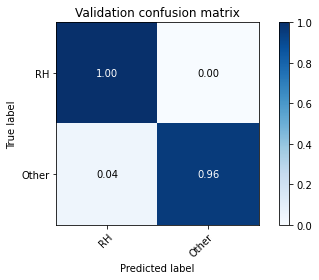

In [31]:
# model = start_kits.util.shallow_net.EEGShallowClassifier(in_chans, labelsize, window_size, return_feature=False)

if cuda:
    model.cuda()
checkpoint = torch.load('right_hand.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

average_acc, average_loss = [], []
setname = 'testset'
dataset = test_set

i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                         batch_size=256)
outputs=None
for i_trials in i_trials_in_batch:
    # Have to add empty fourth dimension to X
    batch_X = dataset.X[i_trials][:, :, :, None]
    batch_y = dataset.y[i_trials]
    net_in = np_to_var(batch_X)
    if cuda:
        net_in = net_in.cuda()
    toutputs = model(net_in)
    if outputs is None:
        temp = toutputs.cpu()
        outputs = temp.detach().numpy()
    else:
        temp = toutputs.cpu()
        outputs = np.concatenate((outputs,temp.detach().numpy()))

net_target = np_to_var(dataset.y)
loss = F.nll_loss(torch.from_numpy(outputs), net_target)
print("{:6s} Loss: {:.5f}".format(setname, float(var_to_np(loss))))
predicted_labels = np.argmax((outputs), axis=1)
accuracy = np.mean(dataset.y  == predicted_labels)

print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
plot_confusion_matrix(dataset.y, predicted_labels, 
                      classes=['RH','Other'], normalize=True,
                      title='Validation confusion matrix')
plt.show()

In [14]:
y_tensor = torch.from_numpy(dataset.y)
y_pred = torch.from_numpy(predicted_labels)

In [15]:
print("Type of a :\n", type(dataset.y))
print("Type of a :\n", type(y_tensor))
# Convert the numpy.ndarray to tensor
print("t:\n", dataset.y)
print("t:\n", y_tensor)

Type of a :
 <class 'numpy.ndarray'>
Type of a :
 <class 'torch.Tensor'>
t:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
t:
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1,

In [16]:
cohenkappa = CohenKappa(num_classes=2)
cohenkappa(y_tensor, y_pred)

tensor(0.9080)